<a href="https://colab.research.google.com/github/Chien-Klein/Cryptocurrency-Prediction/blob/master/Colab_TransferLearning_Chien19124081_Hanh19161019_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount("/content/gdrive")
path = 'gdrive/My Drive/Colab Notebooks/AI/Colab_TransferLearning_Chien19124081_Hanh19161019'
#os.chdir(path)
os.listdir()

Mounted at /content/gdrive


['.config', 'gdrive', 'sample_data']

# 3. Thực hành

## 3.1. Dataset

Để minh họa cho phương pháp transfer learning mình sẽ huấn luyện bài toán dog and cat trên bộ dữ liệu [Sub Dog and Cat](https://github.com/ardamavi/Dog-Cat-Classifier.git) với khoảng 1400 ảnh.



In [ ]:
from google.colab import drive
import os

drive.mount("/content/gdrive")
path = 'gdrive/My Drive/Colab Notebooks/AI'
os.chdir(path)
os.listdir()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['AI_HoiQuyTuyenTinh_VDVideo.ipynb',
 'AI_LinerRegression_PhamHieuHanh_19161019.ipynb',
 'AI_TranslatingMathematicsIntoCode_PhamHieuHanh_19161019.ipynb',
 'AI_LanTruyenNguoc.ipynb',
 'Bản sao của BaiTapGiuaKy.ipynb',
 'BaiTapGiuaKy.ipynb',
 'Bản sao của Nhom5_HTA_Topic5.gslides',
 'Colab_TransferLearning_Chien19124081_Hanh19161019.ipynb']

In [ ]:
!git clone https://github.com/ardamavi/Dog-Cat-Classifier.git
%cd Dog-Cat-Classifier

Cloning into 'Dog-Cat-Classifier'...
remote: Enumerating objects: 1654, done.
remote: Total 1654 (delta 0), reused 0 (delta 0), pack-reused 1654
Receiving objects: 100% (1654/1654), 34.83 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (147/147), done.
Checking out files: 100% (1672/1672), done.
/content/gdrive/My Drive/Colab Notebooks/AI/Dog-Cat-Classifier


Thực hiện khảo sát dữ liệu trước khi huấn luyện model.

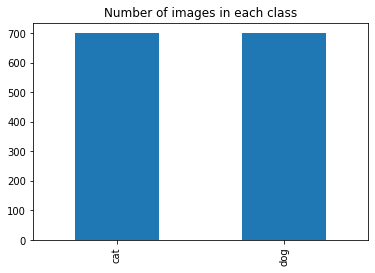

In [ ]:
import pandas as pd
import glob2
import matplotlib.pyplot as plt

dogs = glob2.glob('Data/Train_Data/dog/*.jpg')
dog_labels = ['dog']*len(dogs)
cats = glob2.glob('Data/Train_Data/cat/*.jpg')
cat_labels = ['cat']*len(cats)

labels = dog_labels + cat_labels
image_links = dogs + cats

data = pd.DataFrame({'labels': labels, 'image_links':image_links})
data.groupby(labels).image_links.count().plot.bar()
plt.title('Number of images in each class')
plt.show()

Ta thấy dữ liệu giữa 2 classes là cân bằng với mỗi loại khoảng 700 ảnh. Như vậy chúng ta không xảy ra hiện tượng mất cân bằng dữ liệu.



### 3.1.1. Phân chia tập train/validation

Dữ liệu sẽ được huấn luyện trên tập dữ liệu train và kiểm định trên tập test. Một số qui trình phát triển model ngặt hơn còn phân chia thêm tập dev để fine tunning tham số giữa các mô hình và tập test để kiểm định mô hình trên tập dữ liệu thực tế mà người dùng sinh ra. Tuy nhiên để đơn giản hóa ta sẽ chỉ sử dụng tập train/validation.

Ta phân chia tập train/test theo tỷ lệ 80/20. Để tỷ lệ class cân bằng giữa bộ dữ liệu train và test ta nên sử dụng hàm train_test_split của sklearn với `stratify=y`.

In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_val, y_label_train, y_label_val = train_test_split(image_links, labels, stratify = labels)

print('images_train len: {}, image_test shape: {}'.format(len(images_train), len(images_val)))

images_train len: 1049, image_test shape: 350


### 3.1.2. Data Augumentation

Độ chính xác của một mô hình được cải thiện hay không phần lớn dựa trên 2 yếu tố chính:

    Kiến trúc model mà bạn áp dụng
  
    Kỹ thuật data augumentation

Đặc biệt là với các bài toán có ít dữ liệu thì áp dụng data augumentation sẽ giúp gia tăng số lượng mẫu huấn luyện và cải thiện chất lượng của model.

Để thực hiện data augumentation trên tensorflow, chúng ta có thể config ngay trên ImageDataGenerator.

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
import cv2

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self,
                 all_filenames, 
                 labels, 
                 batch_size, 
                 index2class,
                 input_dim,
                 n_channels,
                 n_classes=2, 
                 normalize=True,
                 zoom_range=[0.8, 1],
                 rotation=15,
                 brightness_range=[0.8, 1],
                 shuffle=True):
        '''
        all_filenames: list toàn bộ các filename
        labels: nhãn của toàn bộ các file
        batch_size: kích thước của 1 batch
        index2class: index của các class
        input_dim: (width, height) đầu vào của ảnh
        n_channels: số lượng channels của ảnh
        n_classes: số lượng các class 
        normalize: có chuẩn hóa ảnh hay không?
        zoom_range: khoảng scale zoom là một khoảng nằm trong [0, 1].
        rotation: độ xoay ảnh.
        brightness_range: Khoảng biến thiên cường độ sáng
        shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
        '''
        self.all_filenames = all_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.index2class = index2class
        self.input_dim = input_dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.normalize = normalize
        self.zoom_range = zoom_range
        self.rotation = rotation
        self.brightness_range = brightness_range
        self.on_epoch_end()

    def __len__(self):
        '''
        return:
          Trả về số lượng batch/1 epoch
        '''
        return int(np.floor(len(self.all_filenames) / self.batch_size))

    def __getitem__(self, index):
        '''
        params:
          index: index của batch
        return:
          X, y cho batch thứ index
        '''
        # Lấy ra indexes của batch thứ index
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # List all_filenames trong một batch
        all_filenames_temp = [self.all_filenames[k] for k in indexes]

        # Khởi tạo data
        X, y = self.__data_generation(all_filenames_temp)

        return X, y

    def on_epoch_end(self):
        '''
        Shuffle dữ liệu khi epochs end hoặc start.
        '''
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, all_filenames_temp):
        '''
        params:
          all_filenames_temp: list các filenames trong 1 batch
        return:
          Trả về giá trị cho một batch.
        '''
        X = np.empty((self.batch_size, *self.input_dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Khởi tạo dữ liệu
        for i, fn in enumerate(all_filenames_temp):
            # Đọc file từ folder name
            img = cv2.imread(fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.input_dim)
            img_reshape = img.reshape(-1, 3)
            
            if self.normalize:
              mean = np.mean(img_reshape, axis=0)
              std = np.std(img_reshape, axis=0)
              img = (img-mean)/std

            if self.zoom_range:
              zoom_scale = 1/np.random.uniform(self.zoom_range[0], self.zoom_range[1])
              (h, w, c) = img.shape
              img = cv2.resize(img, (int(h*zoom_scale), int(w*zoom_scale)), interpolation = cv2.INTER_LINEAR)
              (h_rz, w_rz, c) = img.shape
              start_w = np.random.randint(0, w_rz-w) if (w_rz-w) > 0 else 0
              start_h = np.random.randint(0, h_rz-h) if (h_rz-h) > 0 else 0
              # print(start_w, start_h)
              img = img[start_h:(start_h+h), start_w:(start_w+w), :].copy()
            
            if self.rotation:
              (h, w, c) = img.shape
              angle = np.random.uniform(-self.rotation, self.rotation)
              RotMat = cv2.getRotationMatrix2D(center = (w, h), angle=angle, scale=1)
              img = cv2.warpAffine(img, RotMat, (w, h))

            if self.brightness_range:
              scale_bright = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
              img = img*scale_bright
            
            label = 'dog' if 'dog' in fn else 'cat'
            label = self.index2class[label]
    
            X[i,] = img

            # Lưu class
            y[i] = label
        return X, y

dict_labels = {
    'dog': 0,
    'cat': 1
}

train_generator = DataGenerator(
    all_filenames = images_train,
    labels = y_label_train,
    batch_size = 32,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range=[0.8, 1],
    shuffle = True
)

val_generator = DataGenerator(
    all_filenames = images_val,
    labels = y_label_val,
    batch_size = 16,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = False,
    brightness_range =[0.8, 1],
    shuffle = False
)

Ở đây các phép biến đổi ảnh được viết lại sử dụng numpy và opencv. 

Ý nghĩa và tác động tới ảnh gốc của các tham số chính:

normalize: Có thuẩn hóa mỗi một ảnh với theo phân phối chuẩn bằng cách trừ đi trung bình và chia cho phương sai toàn bộ các pixels tương ứng ở mỗi kênh.

zoom_range: Là một khoảng giá trị phóng đại ảnh: [lower, upper]. Giá trị phóng đại của một ảnh sẽ được sinh ngẫu nhiên nằm trong khoảng zoom_range. Giá trị phóng đại này càng nhỏ thì ảnh sẽ càng được phóng to.

rotation: Góc xoay ngẫu nhiên của một bức ảnh. Thông thường chỉ thiết lập từ 10-20 độ.

brightness_range: Khoảng điều chỉnh độ sáng cho bức ảnh. Độ sáng sẽ là một giá trị ngẫu nhiên từ [minVal, maxVal].

Khi khởi tạo Data Generator với các mô hình sử dụng pretrained model thì chúng ta sẽ phải thực hiện các bước biến đổi dữ liệu trong data pipeline đồng nhất với pipeline được áp dụng trên pretrained model. Khi đó các features được tạo thành từ base network mới có tác dụng phân loại tốt.

Các phép biến đổi trên tập train và validation đã được tham chiếu với biến đổi mà tác giả sử dụng khi thực hiện model pretrain với bộ dữ liệu imagenet từ trước.

### 3.1.3. Kiểm tra dữ liệu Augumentation

Chúng ta cần khảo sát lại xem những step biến đổi trên pipeline đã thay đổi dữ liệu như thế nào? Những biến đổi đó có tạo ra các mẫu phù hợp với thực tế không? Đây là một qui trình cần thiết khi huấn luyện mô hình. 

Để kiểm tra pipeline của ImageGenerator chúng ta có thể khởi tạo vòng lặp loop qua Generator:

In [ ]:
check_aug=['Data/Train_Data/cat/cat.100.jpg']*32

check_generator = DataGenerator(
    all_filenames = check_aug,
    labels = y_label_val,
    batch_size = 20,
    index2class = dict_labels,
    input_dim = (224, 224),
    n_channels = 3,
    n_classes = 2,
    normalize = False,
    zoom_range = [0.5, 1],
    rotation = 15,
    brightness_range = [0.5, 1.5],
    shuffle = False
)

In [ ]:
X_batch, y_batch = check_generator.__getitem__(0)

print(X_batch.shape)
print(y_batch.shape)

(20, 224, 224, 3)
(20,)


In [ ]:
# X_batch[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


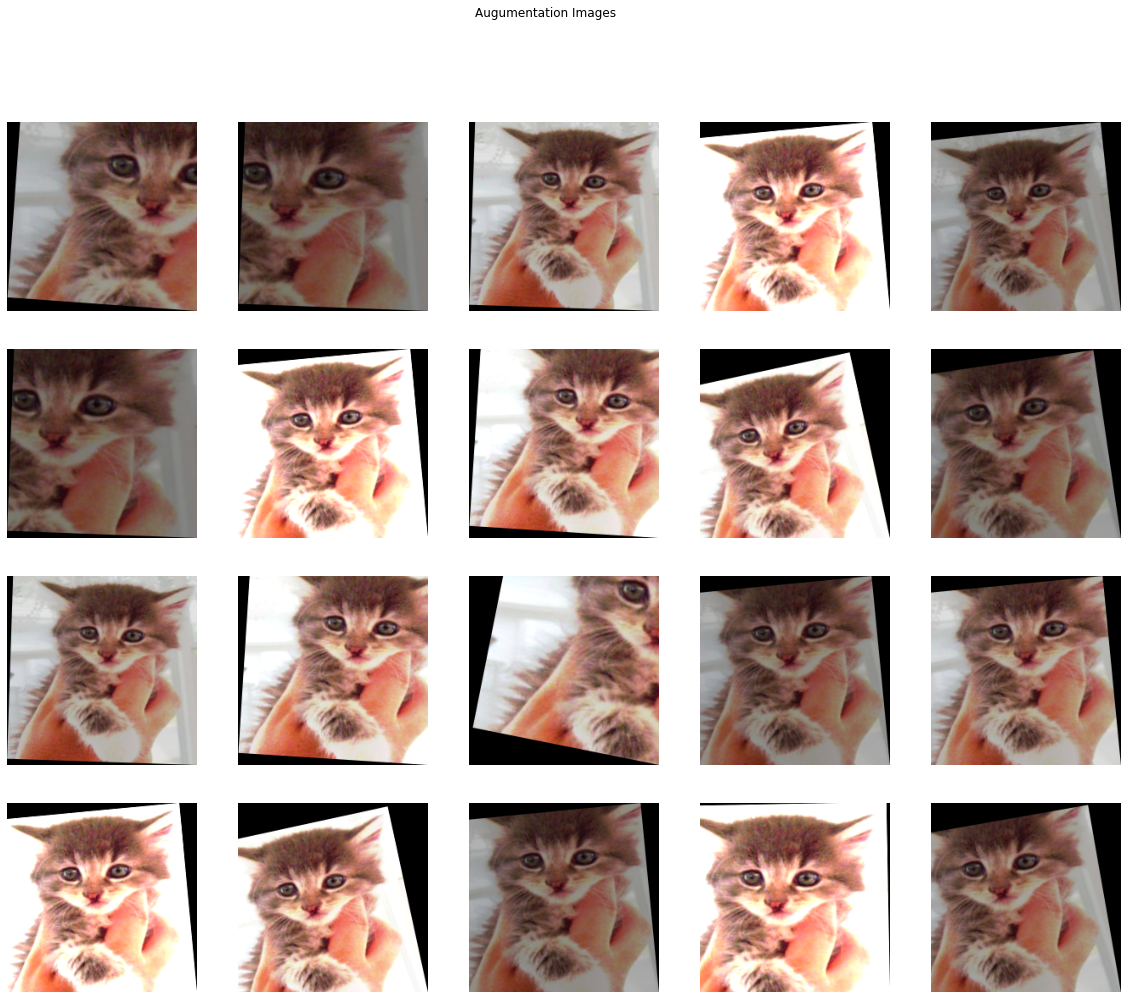

In [ ]:
import matplotlib.pyplot as plt

# Khởi tạo subplot với 4 dòng 5 cột.
fg, ax = plt.subplots(4, 5, figsize=(20, 16))
fg.suptitle('Augumentation Images')

for i in np.arange(4):
  for j in np.arange(5):
    ax[i, j].imshow(X_batch[i + j + j*i]/255.0)
    ax[i, j].set_xlabel('Image '+str(i+j+j*i))
    ax[i, j].axis('off')
plt.show()

Ta có thể thấy với cùng một bức ảnh nhưng đã sinh ra khá nhiều biến thể. Các thay đổi tập trung chủ yếu ở 3 khía cạnh:

* Góc xoay của ảnh.
* Cường độ sáng của ảnh.
* Mức độ phóng đại của ảnh.

  ## 3.2. Huấn luyện model


### 3.2.1. Khởi tạo model huấn luyện

Việc đầu tiên cần thực hiện là khởi tạo base network cho mô hình. Trên keras đã có hầu hết các model pretrain phổ biến trên bộ dữ liệu imagenet. Lý do tác giả lựa chọn bộ dữ liệu này để huấn luyện các model pretrain là vì có tới 1000 classes khác nhau. Do đó hầu như mọi bài toán classification đều có nhãn xuất hiện trong imagenet và có thể tái sử dụng pretrain model.

Ta khởi tạo model như sau:

In [ ]:
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam


base_network = MobileNet(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
flat = Flatten()
den = Dense(1, activation='sigmoid')

model = Sequential([base_network, 
                    flat,
                    den])
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1)                 50177     
                                                                 
Total params: 3,279,041
Trainable params: 3,257,153
Non-trainable params: 21,888
_________________________________________________________________


Ta có thể thấy `base network` là một pretrain model `VGG16` đã được truncate top layer thông qua tham số `include_top=False`. Bài toán của chúng ta có số lượng nhãn khác với imagenet nên sẽ ta gán vào base network một mạng MLP gồm các Layers Fully Connected sao cho layer cuối có số units = số lượng output classes.

Tiếp theo ta sẽ thực hiện quá trình warm up để huấn luyện mô hình nhanh hơn.


### 3.2.2. Warm up

`Warm up` là quá trình cần thiết để mô hình hội tụ nhanh hơn. Warm up sẽ đóng băng lại các layers CNN để cho hệ số của chúng không đổi và train lại trên các layers fully conntected cuối cùng. 

Mục đích của warm up là giữ nguyên được các đặc trưng tổng quát đã được học từ pretrained-model mà những đặc trưng này là tốt vì được huấn luyện trên bộ dữ liệu có kích thước lớn hơn và có độ chính xác cao hơn sao với khởi tạo hệ số ngẫu nhiên. Như vậy phrase 2 (xem hình 2) của mô hình sẽ không thay đổi input $\mathbf{X}$ và coi như chúng ta huấn luyện lại mạng MLP.

In [ ]:
# Frozen base_network
for layer in model.layers[:1]:
  layer.trainable = False

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <keras.engine.functional.Functional object at 0x7efd3bed8210> ; Trainable: False
Layer: <keras.layers.core.flatten.Flatten object at 0x7efd415c5b90> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7efd3be9e4d0> ; Trainable: True


Huấn luyện lại model trên 1 epoch

In [ ]:
import tensorflow as tf

model.fit(train_generator,
          #steps_per_epochs=len(train_generator),
          validation_data=val_generator,
          validation_steps=5,
          epochs=1)

32/32 [==============================] - 199s 6s/step - loss: 1.2569 - accuracy: 0.8281 - val_loss: 6.6136 - val_accuracy: 0.6625


Bạn sẽ thấy accuracy sẽ được cải thiện rất nhanh chỉ sau epoch đầu tiên.

Tuy nhiên bài toán có hiện tượng overfitting khi val_accuracy thấp hơn nhiều so với train_accuracy.

Để giảm thiểu overfitting chúng ta sẽ thực hiện một số hiệu chỉnh đối với mô hình như:

* Mạng nơ ron có khả năng xấp xỉ được hầu hết các hàm số. Khi kiến trúc mạng càng phức tạp và bộ dữ liệu huấn luyện có kích thước nhỏ thì khả năng học được chính xác trên từng điểm dữ liệu sẽ rất tốt. Nhưng việc học này sẽ không tốt trên dữ liệu mới. Chúng ta có thể sử dụng Dropout Layer để giảm thiểu độ phức tạp trong kiến trúc của mô hình. Dropout sẽ làm nhiệm vụ cắt tỉa bớt một số kết nối Fully Connected.

* Để giảm thiểu mức độ phức tạp của hàm số chúng ta cũng có thể sử dụng các phương pháp hiệu chuẩn (regularization) bằng cách thêm vào loss function thành phần norm chuẩn của ma trận hệ số các layers.

$$\mathcal{L}_{reg}(\mathbf{W};\mathbf{X}) = \mathcal{L}(\mathbf{W}; \mathbf{X}) + \lambda ||\mathbf{W}||_{F}^{2}$$

Trên tensorflow chúng ta có thể thêm thành phần hiệu chuẩn bằng cách khai báo trực tiếp vào tham số `kernel_regularizer` của keras layers:







In [ ]:
from tensorflow.keras import regularizers
model.add(Dense(64, input_dim=64,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))



* Một trong những nguyên nhân chủ yếu của overfitting đó là dữ liệu huấn luyện có kích thước quá bé và không tổng quát các trường hợp của ảnh. Trên thực tế bộ dữ liệu [dog and cat gốc](https://www.kaggle.com/c/dogs-vs-cats/data) có kích thước là 25000 ảnh và lớn gấp hàng chục lần dữ liệu huấn luyện với khoảng 1000 ảnh ảnh. Tăng cường thêm dữ liệu huấn luyện cho tập train là một giải pháp có thể cân nhắc tới.

* Fine tunning lại những layers của base network để cải thiện đặc trưng.

### 3.2.3. Fine tunning model

Mục đích chính của việc warm up model là để mô hình hội tụ nhanh hơn tới global optimal value.

Sau khi mô hình đạt ngưỡng tối ưu, sẽ rất khó để chúng ta tăng được thêm độ chính xác hơn nữa. 

Lúc này chúng ta sẽ cần unfrozen các layers của base network và huấn luyện mô hình trên toàn bộ các layers đã được tải trọng số từ pretrain model. Quá trình này được gọi là fine-tunning.

In [ ]:
for layer in model.layers[:1]:
  layer.trainable = True

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.trainable))

Layer: <keras.engine.functional.Functional object at 0x7efd3bed8210> ; Trainable: True
Layer: <keras.layers.core.flatten.Flatten object at 0x7efd415c5b90> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7efd3be9e4d0> ; Trainable: True
Layer: <keras.layers.core.dense.Dense object at 0x7efd3631d3d0> ; Trainable: True


In [ ]:
model.fit(train_generator,
          validation_data = val_generator,
          batch_size = 32,
          epochs = 5)

Epoch 1/5
32/32 [==============================] - 202s 6s/step - loss: 0.6633 - accuracy: 0.8867 - val_loss: 4.8292 - val_accuracy: 0.7649
Epoch 2/5
32/32 [==============================] - 200s 6s/step - loss: 0.5510 - accuracy: 0.9121 - val_loss: 2.4289 - val_accuracy: 0.8601
Epoch 3/5
32/32 [==============================] - 201s 6s/step - loss: 0.4333 - accuracy: 0.9053 - val_loss: 4.0793 - val_accuracy: 0.8571
Epoch 4/5
32/32 [==============================] - 201s 6s/step - loss: 0.4929 - accuracy: 0.9170 - val_loss: 4.2217 - val_accuracy: 0.8244
Epoch 5/5
32/32 [==============================] - 202s 6s/step - loss: 0.3142 - accuracy: 0.9141 - val_loss: 5.5947 - val_accuracy: 0.7976


Chúng ta có thể nhận thấy rằng sau khi thực hiện fine tunning thì đồng thời accuracy trên tập train và tập validation đều tăng và đạt tới ngưỡng >= 80%.

Như vậy fine tunning đã giải quyết được đồng thời 2 vấn đề overfitting và cải thiện accuracy của mô hình.

Đưa thêm hình về accuracy giữa transfer learning và mô hình gốc.

